# Project 1: **Finding Lane Lines on the Road** 
Author: Toshiharu Tabuchi

## **Introduction**
In this project, a computer vision pipeline was developed in order to identified the lane lines on the highway. The topics covered in this project were:

- Opencv (python frontend)
- Image region masking
- Color filtering
- Canny function for edge detection (and why is not always recommended to use)
- Hough transformation for identifying consecutive line segments (and therefore, the lanes).
- Polynomial fitting for obtaining the curve equation for further processing.

### Import packages

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

import glob, os

""" For video manipulation"""
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Functions definitions

In [38]:
def colorFilter(img,lowerColor,upperColor):
    """
    Isolate certain color range of image
    To isolate multiple colors, isolate them separately and bitwise added them
    color is assumed in RGB format
    """
    return cv2.inRange(img,lowerColor,upperColor)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussianBlur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def roi(img, vertices):
    """
    Applies an image mask.
        Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    """defining a blank mask to start with"""
    mask = np.zeros_like(img)   
    
    """defining a 3 channel or 1 channel color to fill the mask with depending
    on the input image
    """
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    """filling pixels inside the polygon defined by "vertices" with the
    fill color    
    """
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    plt.figure()
    plt.imshow(img)
    plt.contour(mask,colors='b', linestyles='dashed')
    
    """returning the image only where mask pixels are nonzero"""
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def laneLinesFit(houghLines,poly_degree=1):
    """
    The points obtained from the Hough transformation are used to
    identify the polynomial curve parameters using the function polyfit
    The outputs of the Lane_lines_fit function are the left and right
    curve 
    """
    leftPoints  =[[],[]]
    rightPoints =[[],[]]
    leftCurve = np.zeros(shape=(1,2))
    rightCurve = np.zeros(shape=(1,2))
    
    for line in houghLines:
        for x1,y1,x2,y2 in line:
            #if m< 0, left line
            m = (y1-y2)/(x1-x2)
#            print(m)
            if m<-0.5:
                leftPoints=np.append(leftPoints,[[x1,x2],[y1,y2]],axis=1)
            elif m>0.5:
               rightPoints=np.append(rightPoints,[[x1,x2],[y1,y2]],axis=1)
    
#    print(rightPoints)
    leftCurve=np.polyfit(leftPoints[1,:],leftPoints[0,:],poly_degree)  #    x=f(y)
    rightCurve=np.polyfit(rightPoints[1,:],rightPoints[0,:],poly_degree)  # x=f(y)
   
    return leftCurve,rightCurve

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = np.copy(img)*0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), (255,0, 0), thickness=2)
## For debugging   
#    comb_img = cv2.addWeighted(image, 0.8, line_img, 1,0.5)
#    plt.figure()        
#    plt.imshow(comb_img)

    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def drawLines(img,leftCurve,rightCurve,verLim):
    """
    This function takes an image, and the curve equation of the left and right
    lanes. Then, it draws this two curves over the image. 

    By default, both equation start at the bottom of the figure and finish at
    y = verLim
    """
    """ Left line initial and end points"""
    imshape = img.shape
    y1_left = imshape[0]
    x1_left = int(y1_left*leftCurve[0]+leftCurve[1])
    
    y2_left = verLim
    x2_left = int(y2_left*leftCurve[0]+leftCurve[1])
    
    """ Right line initial and end points """
    y1_right = imshape[0]
    x1_right = int(y1_right*rightCurve[0]+rightCurve[1])
    
    y2_right = 350
    x2_right = int(y2_right*rightCurve[0]+rightCurve[1])
    
    fit_line_image = np.copy(img)*0
    
    """ Drawing the curves """
    cv2.line(fit_line_image,(x1_left,y1_left),(x2_left,y2_left),(0,0,255),10)
    cv2.line(fit_line_image,(x1_right,y1_right),(x2_right,y2_right),(0,0,255),10)
    
    """
    Overlaying the curves on the input image, applying a previous transparency
    transformation
    """
    return  weighted_img(img,fit_line_image,0.8,1,0)
##############################################################################
## The lane lines processing pipeline
##############################################################################
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
 #   image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  #change to BGR
       
    """ Color filtering"""
    #Filter white color  in BGR order!!!
    lowerWhite = np.array([195,195,195])
    upperWhite = np.array([255,255,255])
    
    #Filter yellow color  in BGR order!!!
    lowerYellow = np.array([80, 190, 215])
    upperYellow = np.array([150, 255, 255]) 

    imageWhites = colorFilter(image,lowerWhite,upperWhite)
    imageYellows = colorFilter(image,lowerYellow,upperYellow)
    imageFiltered = cv2.bitwise_or(imageWhites, imageYellows)
    
   
    """ Masking Region of interest"""
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(430, 300), (530,300), (imshape[1],imshape[0])]], dtype=np.int32)

    maskedImg = roi(imageFiltered,vertices)
    

#for file in glob.glob("*.jpg"):
#    print(file)
#    image = mpimg.imread(file)
#image = mpimg.imread('solidYellowCurve.jpg')
   
#        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        
    """ Define a kernel size and apply Gaussian smoothing"""
    blur_gray = gaussianBlur(maskedImg,kernel_size=5)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 200
 #   edges = canny(blur_gray, low_threshold, high_threshold)
#        plt.figure()
#        plt.imshow(edges)
 
    """
    Define the Hough transform parameters
    Make a blank the same size as our image to draw on
    """
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold =30  #1   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #5 #minimum number of pixels making up a line
    max_line_gap = 15 #1   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    """ Run Hough on edge detected image"""
    houghLines = hough_lines(blur_gray, rho, theta, threshold, min_line_length, max_line_gap)
    #print(houghLines)
    
    """ Identified the curve equation of each, left and right lanes"""
    leftCurve,rightCurve = laneLinesFit(houghLines,poly_degree=1)
    
    verLim = 350 # Vertical limit to draw the identified lane's curves
    
    output_img = drawLines(image,leftCurve,rightCurve,verLim)
 
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)  #change to RGB

    return output_img



## How the pipeline works? Step by step

At the beginning, in order to increase the robustness of the pipeline, the initial images are filtered by colors by the function **colorFilter(image,lowerColor,UpperColor)**. Since the lanes are tipically white or yellow, this two colors were filtered. Depending on different light conditions, colors detected by the camera may vary. For this reason, the algorithm filters a preselected color range, defined by the variables *lowerColor* and *upperColor*.
This is shown in the next lines.

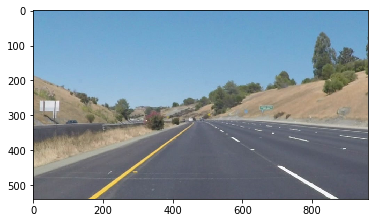

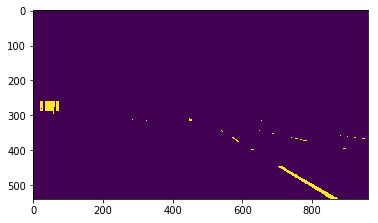

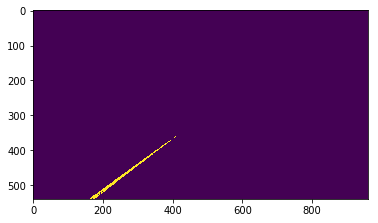

In [49]:
image = cv2.imread('test_images/solidYellowCurve2.jpg')
plt.figure()
image2 = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image2)

#Filter white color  in BGR order!!!
lowerWhite = np.array([195,195,195])
upperWhite = np.array([255,255,255])

imageWhites = colorFilter(image,lowerWhite,upperWhite)
plt.figure()
plt.imshow(imageWhites)

#Filter yellow color  in BGR order!!!
lowerYellow = np.array([80, 190, 215])
upperYellow = np.array([150, 255, 255]) 
imageYellows = colorFilter(image,lowerYellow,upperYellow)
plt.figure()
plt.imshow(imageYellows)

In order to combine both images, and **OR** bitwise operation is used.

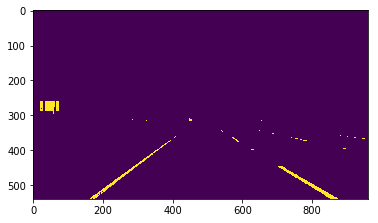

In [40]:
imageFiltered = cv2.bitwise_or(imageWhites, imageYellows)
plt.figure()
plt.imshow(imageFiltered)

Then, the image is masked, in order to eliminate unwanted objects. In the image above, it can be seen that a white panel was also included. The mask used has a trapezoidal shape, which vertices are defined in the next lines.

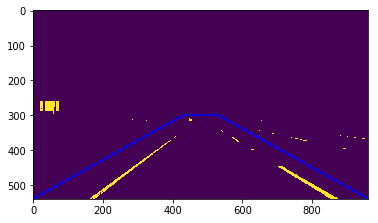

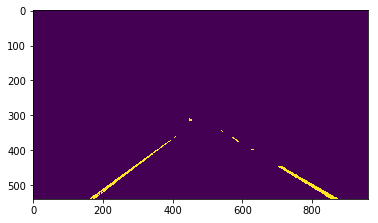

In [41]:
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(430, 300), (530,300), (imshape[1],imshape[0])]], dtype=np.int32)

maskedImg = roi(imageFiltered,vertices)

plt.figure()
plt.imshow(maskedImg)

In this project, only the gaussian smoothing filter is used. The Canny edge detection is no longer used, since in some images, the information of the lanes is limited, because of the light conditions or small size of the pattern on the road (like in the challenge video!). When the Canny edge detection is applied, the number of points available is reduced even more, which affects the performance of the Hough algorithm. By deactivating the Canny edge algorithm, the performance increases, which has been proved with the challenge video. The version without the Canny algorithm can use a higher threshold value in the Hough function, which reduces the instabillity on the detected lanes.


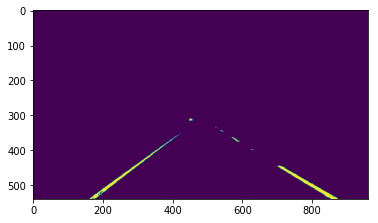

In [42]:
    blur_gray = gaussianBlur(maskedImg,kernel_size=5)
    
    plt.figure()
    plt.imshow(blur_gray)

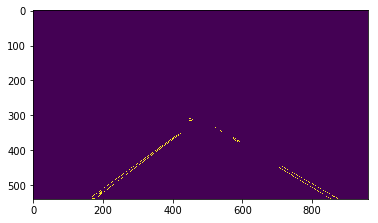

In [43]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 200

edges = canny(blur_gray, low_threshold, high_threshold)

plt.figure()
plt.imshow(edges)

See how the number of pixels is reduced, since the canny edge only detects the border of the objects in the image. This is no longe necessary after the color filtering.

Then, the hough detects the adjacent points which could be forming a line. 


In [46]:
 rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold =30  #1   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #5 #minimum number of pixels making up a line
max_line_gap = 15 #1   # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

""" Run Hough on edge detected image"""
houghLines = hough_lines(blur_gray, rho, theta, threshold, min_line_length, max_line_gap)


The points found by the Hough algorithm are introduced into a polynomial fitting function. In this project, only a first order polynomial (a line) was used. The equation parameters for the left and right lanes are given. Take in account that the function were determined as x = f(y), because it allows an easier manipulation on the image.

In [50]:
leftCurve,rightCurve = laneLinesFit(houghLines, poly_degree=1)

Finally, these parameters are used to draw the left and right detected lanes, show as a overlayed red lines.

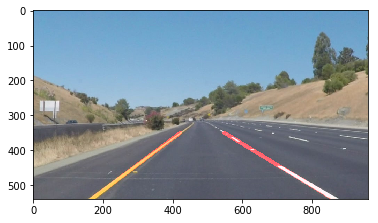

In [51]:
verLim = 350 # Vertical limit to draw the identified lane's curves

output_img = drawLines(image,leftCurve,rightCurve,verLim)
plt.figure()
output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)  #change to RGB
plt.imshow(output_img)

TADA!!!

## Pipeline tested with multiple images
Finally, the pipeline is tested in all the provided images.

### Define input and ouput image folders 

In [31]:
imagesFolder = "test_images"
outputFolder = "images_output"


### Loop for processing all the images
The for loop scan all the images in the declared input folder. At the end of each loop, the output image with the identified lanes over is shown in the console, and also saved in the output folder

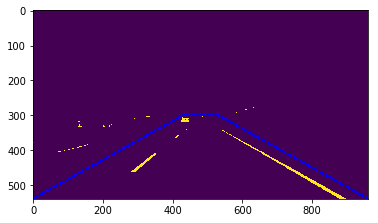

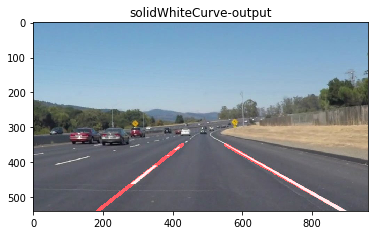

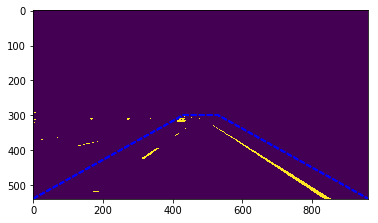

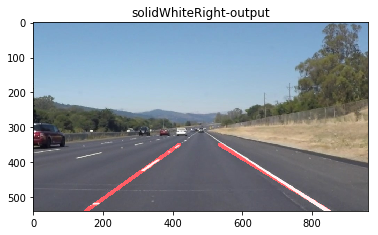

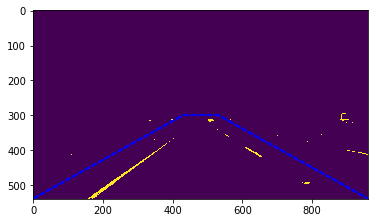

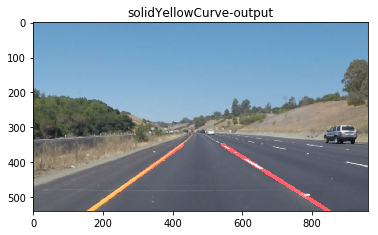

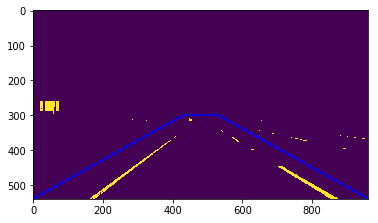

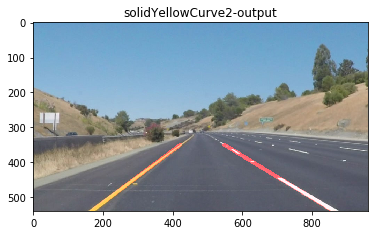

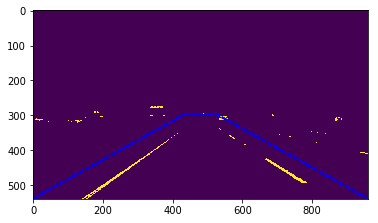

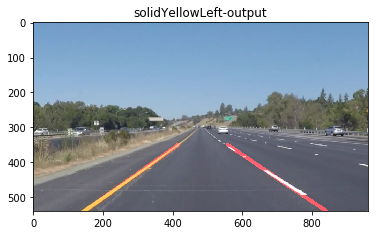

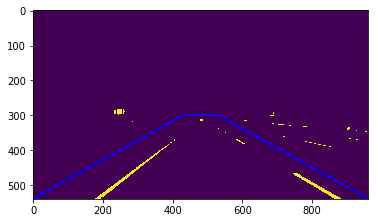

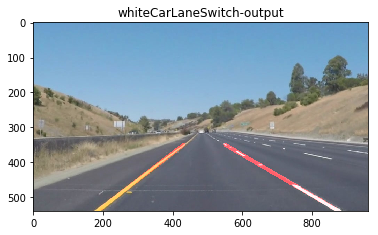

In [32]:
for file in os.listdir(imagesFolder):
    if file.endswith(".jpg"):
#        image = mpimg.imread(imagesFolder+"/"+file)
        image = cv2.imread(imagesFolder+"/"+file)
        
        output_img = process_image(image)
       
        cv2.imwrite(outputFolder+"/"+file[:-4]+'-output.jpg',output_img)
    
        plt.figure()
        plt.title(file[:-4]+'-output')
        plt.imshow(output_img)